In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from IPython.display import display

basic_medical = pd.read_csv(r"C:\Users\dan20_gqofkmv\Dropbox\SPARK,SSCphenotypes\SPARK_Collection_version5\basic_medical_screening.csv", engine = 'python')
individuals = pd.read_csv(r"C:\Users\dan20_gqofkmv\Dropbox\SPARK,SSCphenotypes\SPARK_Collection_version5\individuals_registration.csv", engine = 'python')
bghx_child = pd.read_csv(r'C:\Users\dan20_gqofkmv\Dropbox\SPARK,SSCphenotypes\SPARK_Collection_version5\background_history_child.csv',engine = 'python')
bghx_adult = pd.read_csv(r'C:\Users\dan20_gqofkmv\Dropbox\SPARK,SSCphenotypes\SPARK_Collection_version5\background_history_adult.csv',engine = 'python')

dcdq = pd.read_csv(r'C:\Users\dan20_gqofkmv\Dropbox\SPARK,SSCphenotypes\SPARK_Collection_version5\dcdq.csv', engine = 'python' )
dcdq = dcdq[['subject_sp_id','control_during_movement', 'final_score', 'fine_motor_handwriting', 'general_coordination']].rename(columns = {'final_score':'final_score_dcdq'})

rbs_r = pd.read_csv(r'C:\Users\dan20_gqofkmv\Dropbox\SPARK,SSCphenotypes\SPARK_Collection_version5\rbsr.csv', engine = 'python' )
rbs_r = rbs_r[['subject_sp_id', 'rbsr_validity_flag', 'i_stereotyped_behavior_score', 'ii_self_injurious_score', 'iii_compulsive_behavior_score', 'iv_ritualistic_behavior_score', 'v_sameness_behavior_score', 'vi_restricted_behavior_score', 'total_final_score']].rename(columns = {'total_final_score':'total_final_score_rebs-r'})

rbs_r= rbs_r[rbs_r.rbsr_validity_flag != 1]
rbs_r = rbs_r.drop(['rbsr_validity_flag'], axis = 1)

scq = pd.read_csv(r'C:\Users\dan20_gqofkmv\Dropbox\SPARK,SSCphenotypes\SPARK_Collection_version5\scq.csv', engine = 'python' )

scq= scq[['subject_sp_id', 'scq_measure_validity_flag', 'final_score']].rename(columns = {'final_score':'final_score_scq'})
scq = scq[scq.scq_measure_validity_flag != 1].drop(['scq_measure_validity_flag'], axis =1).dropna(how = 'any', axis = 0)

def show_values_on_bars(axs, values = None):
    def _show_on_single_plot(ax, values):
        if not values:
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + 200
                value = '{}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        else:
            for p,v in zip(ax.patches, values):
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + 200
                value = '{}'.format(v)
                ax.text(_x, _y, value, ha="center")
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax, values)
    else:
        _show_on_single_plot(axs, values)

In [4]:
families_asd_count = individuals[individuals.asd == True].groupby('family_sf_id').count()['asd']
families_asd_count = families_asd_count[families_asd_count >1]
for i in range(2,families_asd_count.max()+1):
    print('there are {} families with {} members with ASD diagnosis'. format(len(families_asd_count[families_asd_count == i]), i))
individuals = individuals[individuals.asd == True]

there are 9036 families with 2 members with ASD diagnosis
there are 1233 families with 3 members with ASD diagnosis
there are 162 families with 4 members with ASD diagnosis
there are 41 families with 5 members with ASD diagnosis
there are 8 families with 6 members with ASD diagnosis
there are 3 families with 7 members with ASD diagnosis


In [5]:
print(f'number of probands = {len(individuals)}')

number of probands = 99447


### what should i do with these families?

In [6]:
relevan_cols = ['subject_sp_id', 'enrolled_multiple', 'age_at_registration_months', 'age_at_registration_years', 'diagnosis_age', 'cognitive_impairment_at_enrollment','registration_year']
ind_for_art = individuals.copy()
individuals = individuals[relevan_cols]
individuals['YOB'] =  individuals.registration_year - individuals.age_at_registration_years

merging basic_medical with relevant_individuals on subjects id

In [7]:
ind_medical = pd.merge(individuals,basic_medical, how = 'inner' , on = 'subject_sp_id' )

In [8]:
print(f'medical hx / number of probands = {len(ind_medical)/len(individuals):.2%}')

medical hx / number of probands = 59.98%


In [9]:
print(f'medical hx / number of probands = {len(ind_medical)/len(individuals):.2%}')

medical hx / number of probands = 59.98%


dropping subjects with no diagnosis age - > consiquently dropping all non proband

In [10]:
ind_medical = ind_medical.dropna(axis = 0, subset = ['diagnosis_age'])
ind_medical.reset_index(drop = True, inplace = True)

 ###computing a variable for daignosis age group
 under 6 = 0
 6-9 = 1
 10 - 17 = 2
 18+ = 3

In [11]:
def age_to_group(df,col):
        age_group = []
        for i in range(len(df[col])):
                if df[col][i] < 72:
                        age_group += [0]
                elif df[col][i] >= 72 and df[col][i] < 120:
                        age_group += [1]
                elif df[col][i] >=120 and df[col][i] < 216:
                        age_group += [2]
                elif df[col][i] >= 216:
                        age_group += [3]
                else:
                        raise ValueError("age must be a number")
        df['age_group'] = age_group

In [12]:
age_to_group(ind_medical, 'diagnosis_age')
len_0_initial = len(ind_medical[ind_medical.diagnosis_age < 72])
len_1_initial = len(ind_medical[ind_medical.diagnosis_age >= 72])

len_male_initial = len(ind_medical[ind_medical.sex == 'Male'])
len_female_initial = len(ind_medical[ind_medical.sex == 'Female'])

In [13]:
print('probands amounts in groups at this point are:')
ind_medical.age_group.value_counts()

probands amounts in groups at this point are:


0    42664
1     9289
2     4786
3     2705
Name: age_group, dtype: int64

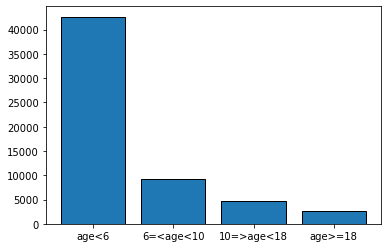

In [14]:
ind_medical.age_group.value_counts()
fig1,ax1 = plt.subplots()
ax1.bar(ind_medical.age_group.value_counts().index,ind_medical.age_group.value_counts(), edgecolor = 'k')
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(['age<6','6=<age<10','10=>age<18', 'age>=18'])
plt.show()


selecting which columns to remove and which to keep

In [15]:
keep = ['subject_sp_id', 'YOB', 'diagnosis_age', 'cognitive_impairment_at_enrollment',
        'sex', 'age_at_eval_months', 'age_at_eval_years','attn_behav', 'behav_adhd', 'behav_conduct',
        'behav_intermitt_explos', 'behav_odd', 'birth_def_bone', 'birth_def_bone_club', 'birth_def_bone_miss', 'birth_def_bone_polydact', 'birth_def_bone_spine', 
        'birth_def_cleft_lip', 'birth_def_cleft_palate', 'birth_def_cns', 'birth_def_cns_brain', 'birth_def_cns_myelo', 'birth_def_fac', 'birth_def_gastro',
        'birth_def_gi_esoph_atres', 'birth_def_gi_hirschprung', 'birth_def_gi_intest_malrot', 'birth_def_gi_pylor_sten', 'birth_def_thorac', 'birth_def_thorac_cdh',
        'birth_def_thorac_heart', 'birth_def_thorac_lung', 'birth_def_urogen', 'birth_def_urogen_hypospad', 'birth_def_urogen_renal', 'birth_def_urogen_renal_agen', 
        'birth_def_urogen_uter_agen',  'birth_etoh_subst', 'birth_ivh', 'birth_oxygen', 'birth_pg_inf', 'birth_prem', 'cog_med', 'dev_id', 'dev_lang', 'dev_lang_dis', 
        'dev_ld', 'dev_motor', 'dev_mutism', 'dev_soc_prag', 'dev_speech', 'eating_probs', 'eating_disorder', 'etoh_subst', 'feeding_dx', 
        'gest_age', 'growth_low_wt', 'growth_macroceph', 'growth_microceph', 'growth_obes', 'growth_short', 'med_cond_birth', 'med_cond_birth_def', 
        'med_cond_growth', 'med_cond_neuro', 'med_cond_visaud', 'mood_anx', 'mood_bipol', 'mood_dep', 'mood_dmd', 'mood_hoard', 'mood_ocd', 'mood_or_anx', 'mood_sep_anx', 
        'mood_soc_anx',  'neuro_inf', 'neuro_lead', 'neuro_sz', 'neuro_tbi', 'pers_dis','schiz', 'sleep_dx',   'sleep_probs', 'tics', 'visaud_blind', 
        'visaud_catar', 'visaud_deaf', 'visaud_strab',  'age_group']
       
ind_med_rel = ind_medical[keep].rename(columns = {'cognitive_impairment_at_enrollment':'cognitive_impairment'})


In [16]:
def dsm_infer(x):
    if x< 1968:
        return 1
    elif 1968 <= x < 1980:
        return 2
    elif 1980 <= x < 1987:
        return 3
    elif 1987 <= x < 1994:
        return 3.5
    elif 1994 <= x < 2000:
        return 4
    elif 2000 <= x < 2013:
        return 4.5
    elif x >= 2013:
        return 5
    

In [17]:
ind_med_rel['YOD'] = np.floor(ind_med_rel.YOB + ind_med_rel.diagnosis_age/12)
ind_med_rel['DSM'] = ind_med_rel.YOD.apply(dsm_infer)
#ind_med_rel.drop('YOD', axis = 1, inplace = True)

In [18]:
# making cognitive impaitment column 1|0 instead true or false (NaN was turned to 0 as well)

ind_med_rel.cognitive_impairment = pd.Series([int(ind_med_rel.cognitive_impairment[i] == True) for i in ind_med_rel.index])

# converting NaN in all medical symptoms to 0
for_filling = ['attn_behav', 'behav_adhd', 'behav_conduct', 'behav_intermitt_explos', 'behav_odd', 'birth_def_bone', 'birth_def_bone_club', 'birth_def_bone_miss',
               'birth_def_bone_polydact', 'birth_def_bone_spine', 'birth_def_cleft_lip', 'birth_def_cleft_palate', 'birth_def_cns', 'birth_def_cns_brain',
               'birth_def_cns_myelo', 'birth_def_fac', 'birth_def_gastro', 'birth_def_gi_esoph_atres', 'birth_def_gi_hirschprung', 'birth_def_gi_intest_malrot',
               'birth_def_gi_pylor_sten', 'birth_def_thorac', 'birth_def_thorac_cdh', 'birth_def_thorac_heart', 'birth_def_thorac_lung', 'birth_def_urogen',
               'birth_def_urogen_hypospad', 'birth_def_urogen_renal', 'birth_def_urogen_renal_agen', 'birth_def_urogen_uter_agen', 'birth_etoh_subst', 'birth_ivh', 
               'birth_oxygen', 'birth_pg_inf', 'birth_prem', 'cog_med', 'dev_id', 'dev_lang', 'dev_lang_dis', 'dev_ld', 'dev_motor', 'dev_mutism', 'dev_soc_prag',
               'dev_speech', 'eating_probs', 'eating_disorder', 'etoh_subst', 'feeding_dx', 'growth_low_wt', 'growth_macroceph', 'growth_microceph', 'growth_obes',
               'growth_short', 'med_cond_birth', 'med_cond_birth_def', 'med_cond_growth', 'med_cond_neuro', 'med_cond_visaud', 'mood_anx', 'mood_bipol', 'mood_dep',
               'mood_dmd', 'mood_hoard', 'mood_ocd', 'mood_or_anx', 'mood_sep_anx', 'mood_soc_anx', 'neuro_inf', 'neuro_lead', 'neuro_sz', 'neuro_tbi', 'pers_dis',
               'schiz', 'sleep_dx', 'sleep_probs', 'tics', 'visaud_blind', 'visaud_catar', 'visaud_deaf', 'visaud_strab']

ind_med_rel[for_filling]=ind_med_rel[for_filling].fillna(0)

filltering and combining bghx tables

In [19]:
bghx_child_keep = ['subject_sp_id', 'mother_highest_education', 'father_highest_education', 'annual_household_income', 'susp_cause_genetic','susp_cause_medical', 
                   'susp_cause_enviro', 'susp_cause_preg', 'susp_cause_pg_drug_etoh', 'susp_cause_birth', 'susp_cause_infection', 'susp_cause_vaccine',
                   'susp_cause_other', 'twin_mult_birth', 'zygosity', 'twin_asd',  'twin_partic', 'family_hx_asd_mother', 'family_hx_asd_father', 
                   'family_hx_asd_brother', 'family_hx_asd_sister', 'family_hx_asd_mat_aunt_uncle', 'family_hx_asd_pat_aunt_uncle', 'family_hx_asd_mat_grandparent',
                   'family_hx_asd_pat_grandparent', 'family_hx_asd_mat_cousin', 'family_hx_asd_pat_cousin', 'family_hx_asd_other', 'family_hx_asd_none', 
                   'diagnosis_rescinded']
bghx_adult_keep = ['subject_sp_id', 'mother_highest_education', 'father_highest_education', 'annual_household_income','twin_multiple_birth', 'zygosity', 'twin_asd', 'twin_partic',
                   'family_hx_asd_mother', 'family_hx_asd_father', 'family_hx_asd_brother', 'family_hx_asd_sister', 'family_hx_asd_mat_aunt_uncle', 'family_hx_asd_pat_aunt_uncle',
                   'family_hx_asd_mat_grandparent', 'family_hx_asd_pat_grandparent', 'family_hx_asd_mat_cousin', 'family_hx_asd_pat_cousin', 'family_hx_asd_child',
                   'family_hx_asd_other', 'family_hx_asd_none', 'susp_cause_genetic', 'susp_cause_medical', 'susp_cause_enviro', 'susp_cause_preg', 'susp_cause_pg_drug_etoh',
                   'susp_cause_birth', 'susp_cause_infection', 'susp_cause_vaccine', 'susp_cause_dk', 'susp_cause_other','diagnosis_rescinded']

In [20]:
a = bghx_child.diagnosis_rescinded[bghx_child.diagnosis_rescinded!='no'].dropna()
display(a.head(4))
print('\nnumber of probands with remmited or refuted diagnosis in bghx_child: {}'.format(len(a)))

17     yes_remitted
144    yes_remitted
152     yes_refuted
184     yes_refuted
Name: diagnosis_rescinded, dtype: object


number of probands with remmited or refuted diagnosis in bghx_child: 2708


In [21]:
a = bghx_adult.diagnosis_rescinded[bghx_adult.diagnosis_rescinded!='no'].dropna()
display(a.head(4))
print('\nnumber of probands with remmited or refuted diagnosis in bghx_child: {}'.format(len(a)))

14    yes_refuted
24    yes_refuted
26    yes_refuted
31    yes_refuted
Name: diagnosis_rescinded, dtype: object


number of probands with remmited or refuted diagnosis in bghx_child: 267


In [22]:
bghx_child = bghx_child[bghx_child_keep].rename(columns = {'twin_multiple_birth':'twin_mult_birth'})
bghx_adult = bghx_adult[bghx_adult_keep].rename(columns = {'twin_multiple_birth':'twin_mult_birth'})


In [23]:
def combine_dup_cols(df):
    x = sorted([x for x in df.columns if x.endswith('_x')])
    y = sorted([y for y in df.columns if y.endswith('_y')])
    for col_x, col_y in zip(x,y):
        df[col_x] = df[col_x].fillna(df[col_y])
    df = df.drop(y, axis = 1)
    df = df.rename(columns = {col:col_t for col,col_t in zip(x,[i[:-2] for i in x])})
    return df

bghx = pd.merge(bghx_child, bghx_adult, on = 'subject_sp_id', how = 'outer')
bghx = combine_dup_cols(bghx)

In [24]:
bghx_number = len(individuals.merge(bghx, on = 'subject_sp_id', how = 'inner'))
print(f'bghx / number of probands = {bghx_number/len(individuals):.2%}')

bghx / number of probands = 40.56%


Probands for which diagnosis was remitted or refuted are removed from the data

In [25]:
bghx = bghx[(bghx.diagnosis_rescinded != 'yes_remitted')&(bghx.diagnosis_rescinded != 'yes_refuted')]
bghx = bghx.drop('diagnosis_rescinded', axis = 1)

fill binary colmns' nans with 0

In [26]:
filnancols = ['susp_cause_genetic', 'susp_cause_medical',
       'susp_cause_enviro', 'susp_cause_preg', 'susp_cause_pg_drug_etoh',
       'susp_cause_birth', 'susp_cause_infection', 'susp_cause_vaccine',
       'susp_cause_other', 'twin_partic', 'family_hx_asd_mother', 'family_hx_asd_father',
       'family_hx_asd_brother', 'family_hx_asd_sister',
       'family_hx_asd_mat_aunt_uncle', 'family_hx_asd_pat_aunt_uncle',
       'family_hx_asd_mat_grandparent', 'family_hx_asd_pat_grandparent',
       'family_hx_asd_mat_cousin', 'family_hx_asd_pat_cousin',
       'family_hx_asd_other', 'family_hx_asd_none', 'family_hx_asd_child',
       'susp_cause_dk']
bghx.loc[:,filnancols] = bghx.loc[:,filnancols].fillna(0)

In [27]:
bghx.twin_asd = bghx.twin_asd.replace(['no', 'yes','not_sure'],[0,1,2]).fillna(0)

aggregation of all family asd to four variables 

In [28]:
bghx = bghx.reset_index(drop = True)

overall_family_asd = np.array([1 if bghx.family_hx_asd_mother[i] ==1 or bghx.family_hx_asd_father[i] ==1 or bghx.twin_asd[i] ==1 or bghx.family_hx_asd_brother[i] ==1 or bghx.family_hx_asd_sister[i] ==1 or bghx.family_hx_asd_mat_aunt_uncle[i] ==1 or bghx.family_hx_asd_pat_aunt_uncle[i] ==1 or bghx.family_hx_asd_mat_grandparent[i] ==1 or bghx.family_hx_asd_pat_grandparent[i] ==1 or bghx.family_hx_asd_mat_cousin[i] ==1 or bghx.family_hx_asd_pat_cousin[i] ==1  or bghx.family_hx_asd_other[i] ==1 else 0 for i in bghx.index])

nuclear_family_asd = np.array([1 if bghx.family_hx_asd_mother[i] ==1 or bghx.family_hx_asd_father[i] ==1 or bghx.twin_asd[i] ==1 or bghx.family_hx_asd_brother[i] ==1 or bghx.family_hx_asd_sister[i] ==1 else 0 for i in bghx.index])

extended_family_asd = np.array([1 if bghx.family_hx_asd_mat_aunt_uncle[i] ==1 or bghx.family_hx_asd_pat_aunt_uncle[i] ==1 or bghx.family_hx_asd_mat_grandparent[i] ==1 or bghx.family_hx_asd_pat_grandparent[i] ==1 or bghx.family_hx_asd_mat_cousin[i] ==1 or bghx.family_hx_asd_pat_cousin[i] ==1  or bghx.family_hx_asd_other[i] ==1 else 0 for i in bghx.index])

bghx['overall_family_asd'] = overall_family_asd
bghx['nuclear_family_asd'] = nuclear_family_asd
bghx['extended_family_asd'] = extended_family_asd
bghx = bghx.drop(['family_hx_asd_child','twin_asd', 'family_hx_asd_mother', 'family_hx_asd_father', 'family_hx_asd_brother', 'family_hx_asd_sister', 'family_hx_asd_mat_aunt_uncle', 'family_hx_asd_pat_aunt_uncle', 'family_hx_asd_mat_grandparent', 'family_hx_asd_pat_grandparent', 'family_hx_asd_mat_cousin', 'family_hx_asd_pat_cousin', 'family_hx_asd_other', 'family_hx_asd_none'], axis = 1)


start the merges

In [29]:
spark =  pd.merge(ind_med_rel,bghx, how = 'inner', on = 'subject_sp_id')

In [30]:
print('probands amounts in groups at this point are:')
spark.age_group.value_counts()

probands amounts in groups at this point are:


0    26483
1     5725
2     2819
3     1713
Name: age_group, dtype: int64

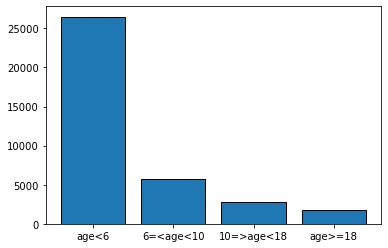

In [31]:
spark.age_group.value_counts()
fig1,ax1 = plt.subplots()
ax1.bar(spark.age_group.value_counts().index,spark.age_group.value_counts(), edgecolor = 'k')
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(['age<6','6=<age<10','10=>age<18', 'age>=18'])
plt.show()


In [32]:
dfs = [spark,dcdq,rbs_r,scq]
spark = reduce(lambda left,right: pd.merge(left,right, on = 'subject_sp_id',  how = 'inner'), dfs)

In [33]:
for df in dfs:
    bghx_number = len(individuals.merge(df, on = 'subject_sp_id', how = 'inner'))
    print(f'df / number of probands = {bghx_number/len(individuals):.2%}')

df / number of probands = 36.94%
df / number of probands = 27.12%
df / number of probands = 36.28%
df / number of probands = 48.26%


In [34]:
print('probands amounts in groups at this point are:')
spark.age_group.value_counts()

probands amounts in groups at this point are:


0    17992
1     4350
2     1290
Name: age_group, dtype: int64

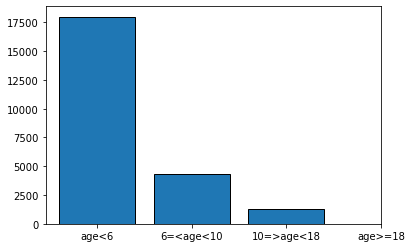

In [35]:
spark.age_group.value_counts()
fig1,ax1 = plt.subplots()
ax1.bar(spark.age_group.value_counts().index,spark.age_group.value_counts(), edgecolor = 'k')
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(['age<6','6=<age<10','10=>age<18', 'age>=18'])
plt.show()


combining age groups 6-9 + 10-18

In [36]:
spark.age_group = spark.age_group.replace(2,1)

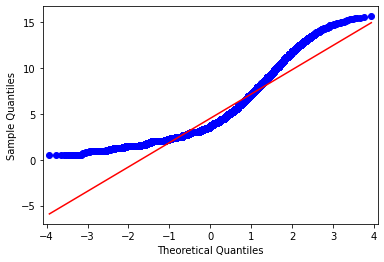

In [42]:
from statsmodels.graphics.gofplots import qqplot
qqplot(spark.diagnosis_age/12, line='s')
plt.show()

In [37]:
display((spark[spark.age_group == 0].diagnosis_age/12).mean())
display((spark[spark.age_group == 0].diagnosis_age/12).std())
display((spark[spark.age_group == 0].diagnosis_age/12).sem())

display((spark[spark.age_group == 0].diagnosis_age/12).quantile([0.25,0.5,0.75]))

3.286016007114285

1.1725448961651732

0.008741576436750071

0.25    2.416667
0.50    3.083333
0.75    4.083333
Name: diagnosis_age, dtype: float64

In [49]:
display(len(spark[spark.age_group == 1].diagnosis_age/12))
display(spark.age_group.value_counts(normalize=True))
display((spark[spark.age_group == 1].diagnosis_age/12).mean())
display((spark[spark.age_group == 1].diagnosis_age/12).std())
display((spark[spark.age_group == 1].diagnosis_age/12).sem())

display((spark[spark.age_group == 1].diagnosis_age/12).quantile([0.25,0.5,0.75]))
display(spark[spark.age_group == 1].sex.value_counts())
display(spark[spark.age_group == 1].sex.value_counts(normalize= True))

5640

0    0.761341
1    0.238659
Name: age_group, dtype: float64

8.500886524822723

2.1034374196707186

0.028008512442335258

0.25    6.833333
0.50    8.000000
0.75    9.666667
Name: diagnosis_age, dtype: float64

Male      4322
Female    1318
Name: sex, dtype: int64

Male      0.766312
Female    0.233688
Name: sex, dtype: float64

In [45]:
display((spark.diagnosis_age/12).mean())
display((spark.diagnosis_age/12).std())
display((spark.diagnosis_age/12).sem())

display((spark.diagnosis_age/12).quantile([0.25,0.5,0.75]))
display(spark.sex.value_counts())
display(spark.sex.value_counts(normalize= True))

4.5305941096817675

2.6540659474095416

0.01726479678634394

0.25    2.583333
0.50    3.666667
0.75    5.750000
Name: diagnosis_age, dtype: float64

Male      18620
Female     5012
Name: sex, dtype: int64

Male      0.787915
Female    0.212085
Name: sex, dtype: float64

Text(0, 0.5, 'Diagnosis age (years)')

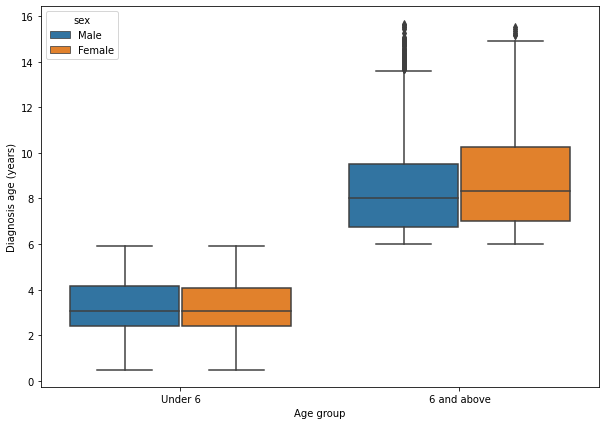

In [120]:
ages = spark[['age_group', 'diagnosis_age', 'sex', 'YOB', 'YOD']].copy()
ages.loc[:,'diagnosis_age'] = ages.loc[:, 'diagnosis_age']/12
ages.loc[:,'YOD'] = np.floor(ages.loc[:, 'YOD'])
fig,ax = plt.subplots(figsize = (10, 7))

g = sns.boxplot(data = ages, x = 'age_group', y = 'diagnosis_age', hue = 'sex',ax = ax)
ax.set_xticklabels(['Under 6','6 and above'])
ax.set_xlabel('Age group')
ax.set_ylabel('Diagnosis age (years)')

Text(0, 0.5, 'Year of birth')

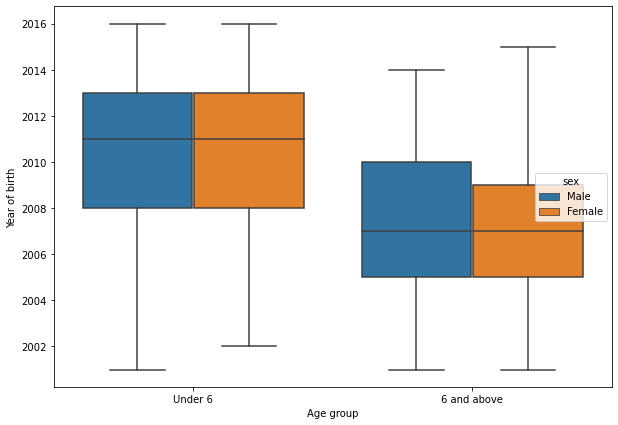

In [121]:
fig,ax = plt.subplots(figsize = (10, 7))

g = sns.boxplot(data = ages, x = 'age_group', y = 'YOB', hue = 'sex',ax = ax)
ax.set_xticklabels(['Under 6','6 and above'])
ax.set_xlabel('Age group')
ax.set_ylabel('Year of birth')

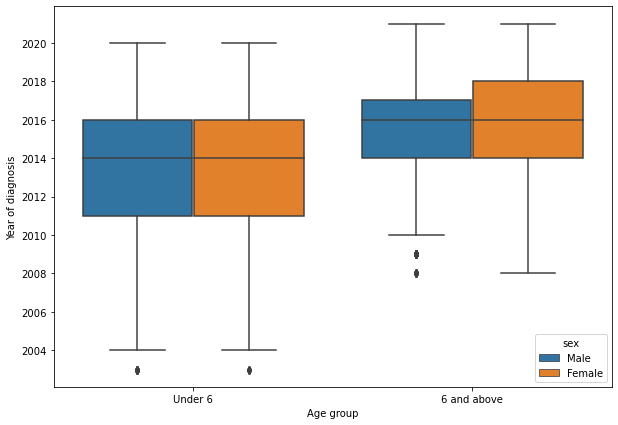

In [122]:
fig,ax = plt.subplots(figsize = (10, 7))

g = sns.boxplot(data = ages, x = 'age_group', y = 'YOD', hue = 'sex',ax = ax)
ax.set_xticklabels(['Under 6','6 and above'])
ax.set_xlabel('Age group')
ax.set_ylabel('Year of diagnosis')
ax.set_yticks(np.arange(2004,2022,2).astype(int))

Text(0.5, 1.0, 'Diagnosis age distribution')

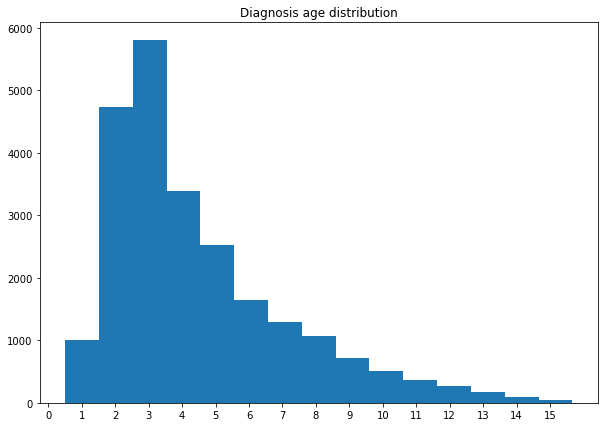

In [123]:
fig1,ax1 = plt.subplots(figsize = (10, 7))
ax1.hist((spark.diagnosis_age/12),15)
ax1.set_xticks(range(0,16))
ax1.set_title('Diagnosis age distribution')

dealing with strings in data

In [137]:
all_vars = pd.concat(pd.read_excel(r'C:\Users\dan20_gqofkmv\Dropbox\SPARK,SSCphenotypes\SPARK_Collection_version5\SPARK Data Dictionary.xlsx', sheet_name=None, usecols='A:B'), ignore_index=True)

In [138]:
all_vars = all_vars[all_vars.variable.isin(spark.columns)]
all_vars = all_vars.drop_duplicates().reset_index(drop = True)
# all_vars.to_csv('all_vars.csv', index = False)
spark.columns[~spark.columns.isin(all_vars.variable)]

Index(['YOB', 'cognitive_impairment', 'age_group', 'YOD', 'DSM',
       'overall_family_asd', 'nuclear_family_asd', 'extended_family_asd',
       'final_score_dcdq', 'total_final_score_rebs-r', 'final_score_scq'],
      dtype='object')

In [124]:
spark.sex = spark.sex.replace(['Male','Female'], [0,1])
spark.gest_age = spark.gest_age.fillna(-1)
spark.mother_highest_education = spark.mother_highest_education.replace({'did_not_attend_high_school':0,
'some_high_school':1,
'ged_diploma':2,
'high_school_graduate':3,
np.nan:4,
'trade_school':5,
'some_college':6,
'associate_degree':7,
'baccalaureate_degree':8,
'graduate_or_professional_degree':9})

spark.father_highest_education = spark.father_highest_education.replace({'did_not_attend_high_school':0,
'some_high_school':1,
'ged_diploma':2,
'high_school_graduate':3,
np.nan:4,
'trade_school':5,
'some_college':6,
'associate_degree':7,
'baccalaureate_degree':8,
'graduate_or_professional_degree':9})

spark.annual_household_income = spark.annual_household_income.replace({'less_than_20000':7,
'21000_35000':2,
'36000_50000':3,
'51000_65000':4,
np.nan:8,
'66000_80000':5,
'81000_100000':6,
'101000_130000':0,
'131000_160000':1,
'over_161000':9})

spark = pd.get_dummies(spark, columns = ['zygosity','twin_mult_birth'])

In [125]:
spark = spark.drop_duplicates(subset='subject_sp_id', keep = 'first')
left_ids = spark.subject_sp_id
# left_ids.to_csv('left_ids.csv')
ml_all_spark = spark.drop(['subject_sp_id'], axis = 1)


In [141]:
# spark.to_csv('spark_with_ages.csv', index = False)
irrelevant = ['age_at_eval_months', 'age_at_eval_years', 'diagnosis_age', 'YOD']
ml_all_spark = ml_all_spark.drop(irrelevant, axis = 1)
#ml_all_spark.to_csv('ml_all_spark.csv', index = False)

In [142]:
print('probands amounts in groups at this point are:')
ml_all_spark.age_group.value_counts()

probands amounts in groups at this point are:


0    17992
1     5640
Name: age_group, dtype: int64

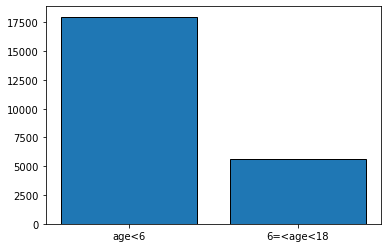

In [143]:
ml_all_spark.age_group.value_counts()
fig1,ax1 = plt.subplots()
ax1.bar(ml_all_spark.age_group.value_counts().index,ml_all_spark.age_group.value_counts(), edgecolor = 'k')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['age<6','6=<age<18'])
plt.show()


In [144]:
print('number of subjects: {}'.format(len(ml_all_spark)))


number of subjects: 23632


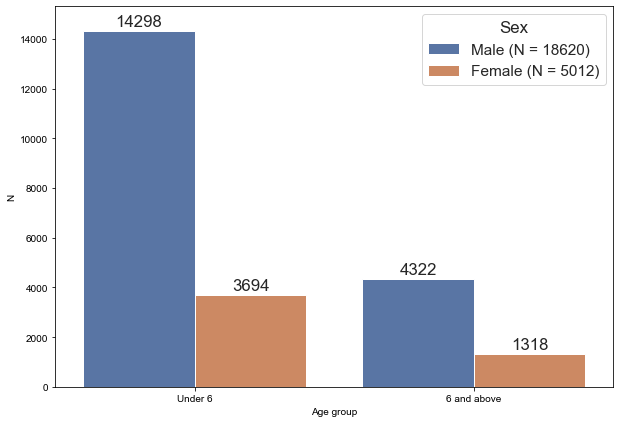

In [145]:
fig, ax = plt.subplots(figsize = (10,7))
sns.set(font_scale = 1.4, style = 'white')
sns.countplot(data = ml_all_spark, x = 'age_group', hue = 'sex', ax = ax)
ax.set_ylim(0, ax.get_ylim()[1]+300)
ax.set_xticklabels(['Under 6','6 and above'])
ax.set_xlabel('Age group')
ax.set_ylabel('N')
new_labels = ['Male (N = {})'.format(ml_all_spark.sex.value_counts()[0]), 'Female (N = {})'.format(ml_all_spark.sex.value_counts()[1])]
plt.legend(title='Sex', loc='upper right', labels=new_labels)
show_values_on_bars(ax)

In [146]:
after_joining_rates = pd.DataFrame({'rate':[len(ml_all_spark[ml_all_spark.age_group == 0])/len_0_initial,
                                 len(ml_all_spark[ml_all_spark.age_group == 1])/len_1_initial], 'name': ['early proportion', 'late proportion']})
after_joining_rates

,rate,name
0,0.421714,early proportion
1,0.336114,late proportion


Text(0.5, 0, '')

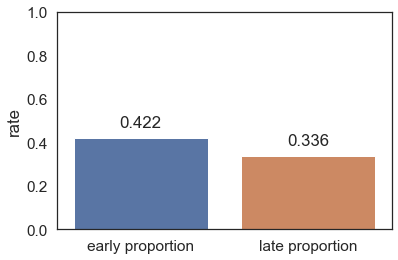

In [147]:
sns.barplot(data = after_joining_rates, x = 'name', y = 'rate')
plt.ylim([0,1])
for p in plt.gca().patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + 0.05
                value = '{:.3f}'.format(p.get_height())
                plt.text(_x, _y, value, ha="center")
plt.xlabel('')

Text(0.5, 0, '')

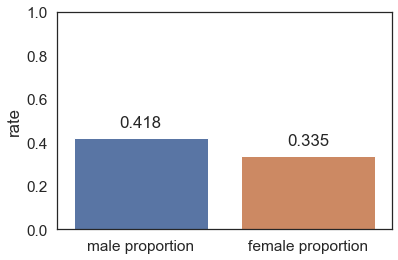

In [148]:
sex_after_joining_rates = pd.DataFrame({'rate':[len(ml_all_spark[ml_all_spark.sex == 0])/len_male_initial,
                                 len(ml_all_spark[ml_all_spark.sex == 1])/len_female_initial], 'name': ['male proportion', 'female proportion']})

sns.barplot(data = sex_after_joining_rates, x = 'name', y = 'rate')
plt.ylim([0,1])
for p in plt.gca().patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + 0.05
                value = '{:.3f}'.format(p.get_height())
                plt.text(_x, _y, value, ha="center")
plt.xlabel('')

In [149]:
left_cols = pd.Series(ml_all_spark.columns)
# left_cols.to_csv('left_cols.csv')

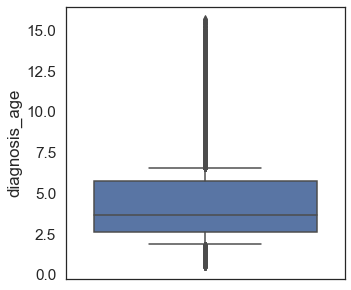

In [174]:

sns.boxplot(y = spark.diagnosis_age/12, whis=0.25)
plt.rcParams['figure.figsize'] = (5,5)

In [126]:
ind_for_art = ind_for_art[ind_for_art.subject_sp_id.isin(left_ids)]

In [127]:
print(f'probands registered to the study between {rel_ind_for_article.registration_year.min()} -  {rel_ind_for_article.registration_year.max()}')

probands registered to the study between 2015 -  2020


In [132]:
pd.set_option('display.max_columns', 500)
ind_for_art

,subject_sp_id,family_sf_id,biomother_sp_id,biofather_sp_id,biochild_sp_id,sex,asd,enrolled_multiple,multiple_birth,depend_adult,age_at_registration_months,age_at_registration_years,registration_year,asd_validity_flag,asd_confound_flag,age_validity_flag,individual_data_validity,control_sibling_flag,asd_dx_changed_flag,diagnosis_age,diagnosis,diagnosis_source_team_health,diagnosis_source_team_school,diagnosis_source_MD_ped,diagnosis_source_MD_spec,diagnosis_source_clin_psych,diagnosis_source_other,diagnosis_source_ns,ASD_services,iep_asd,cognitive_impairment_at_enrollment,language_level_at_enrollment,referral,race_asian,race_african_amer,race_native_amer,race_native_hawaiian,race_white,race_other,hispanic,race_more_than_one_calc
1,SP0000003,SF0000003,SP0000002,NaN,NaN,Male,True,NaN,No,False,123.0,10.0,2016,NaN,1.0,NaN,NaN,NaN,NaN,33.0,Autism or Autistic Disorder,1.0,1.0,1.0,1.0,NaN,NaN,NaN,True,True,True,No words/does not speak,A clinical site,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0
2,SP0000013,SF0000013,SP0000010,NaN,NaN,Male,True,NaN,No,False,168.0,14.0,2016,NaN,NaN,NaN,NaN,NaN,NaN,166.0,Asperger's Disorder,1.0,1.0,NaN,NaN,NaN,NaN,NaN,True,True,False,Uses longer sentences of his/her own and is ab...,A clinical site,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9,SP0000026,SF0000026,SP0000046,SP0255776,NaN,Female,True,Twin,Twin,False,65.0,5.0,2015,NaN,NaN,NaN,NaN,NaN,NaN,45.0,Autism Spectrum Disorder,1.0,NaN,NaN,1.0,1.0,NaN,NaN,True,True,False,Uses longer sentences of his/her own and is ab...,A clinical site,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
18,SP0000030,SF0000030,SP0001693,NaN,NaN,Female,True,NaN,No,False,91.0,7.0,2016,NaN,NaN,NaN,NaN,NaN,NaN,69.0,Autism Spectrum Disorder,1.0,NaN,1.0,NaN,NaN,NaN,NaN,False,True,False,Uses longer sentences of his/her own and is ab...,A clinical site,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
22,SP0000033,SF0000033,SP0000067,SP0000684,NaN,Male,True,NaN,No,False,93.0,7.0,2015,NaN,NaN,NaN,NaN,NaN,NaN,32.0,Autism or Autistic Disorder,NaN,NaN,NaN,NaN,1.0,NaN,NaN,True,True,False,Uses longer sentences of his/her own and is ab...,A clinical site,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248244,SP0422655,SF0422655,SP0422654,NaN,NaN,Male,True,NaN,No,False,144.0,12.0,2020,NaN,NaN,NaN,NaN,NaN,NaN,126.0,Autism or Autistic Disorder,NaN,1.0,NaN,NaN,NaN,1.0,NaN,False,True,False,Uses longer sentences of his/her own and is ab...,A clinical site,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
248295,SP0422769,SF0422769,SP0422767,NaN,NaN,Female,True,NaN,No,False,112.0,9.0,2020,NaN,1.0,NaN,NaN,NaN,NaN,39.0,Autism or Autistic Disorder,NaN,1.0,1.0,NaN,NaN,NaN,NaN,True,True,False,Uses longer sentences of his/her own and is ab...,A clinical site,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0
248432,SP0423080,SF0423080,SP0423076,SP0423100,NaN,Male,True,NaN,No,False,133.0,11.0,2020,1.0,NaN,NaN,NaN,NaN,NaN,91.0,Autism Spectrum Disorder,NaN,NaN,NaN,NaN,1.0,NaN,NaN,False,False,True,Uses longer sentences of his/her own and is ab...,A clinical site,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
248462,SP0423132,SF0423132,SP0423131,SP0423157,NaN,Male,True,NaN,No,False,113.0,9.0,2020,NaN,NaN,NaN,NaN,NaN,NaN,111.0,Asperger's Disorder,1.0,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,Uses longer sentences of his/her own and is ab...,A clinical site,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [56]:
clus_0_ind = [1,14,17,18,24,29,31,42,43,45,56,66,69,92,94,106,115,117,122,126,143,144,167,168,190,213,217,224,242,268,278,280,283,295,303,304,329,337,347,355,376,377,380,391,405,412,414,418,423,430,431,435,449,458,477,493,500,502,524,542,559,562,566,569,570,574,579,580,581,588,589,600,602,612,618,621,634,643,661,669,687,695,706,710,730,732,733,737,757,775,777,798,800,801,809,811,813,814,821,831,833,856,858,872,877,885,886,911,912,913,916,917,921,925,928,944,958,960,972,976,986,987,991,992,994,1014,1021,1046,1054,1076,1078,1086,1095,1099,1106,1110,1117,1136,1137,1145,1155,1166,1172,1175,1181,1195,1215,1216,1218,1221,1227,1229,1268,1270,1275,1283,1296,1306,1307,1308,1323,1329,1332,1343,1359,1360,1361,1369,1397,1399,1405,1414,1434,1440,1457,1458,1465,1496,1500,1504,1519,1522,1525,1529,1537,1538,1540,1570,1574,1586,1590,1608,1633,1635,1643,1644,1645,1672,1673,1683,1724,1727,1736,1747,1754,1755,1771,1779,1789,1795,1799,1824,1826,1847,1851,1857,1860,1867,1871,1876,1884,1900,1909,1916,1941,1956,1959,1986,1989,2017,2039,2042,2043,2056,2060,2062,2067,2068,2069,2084,2086,2087,2088,2103,2106,2112,2175,2187,2196,2200,2201,2227,2232,2235,2261,2274,2295,2312,2314,2325,2343,2347,2348,2352,2363,2376,2427,2431,2439,2453,2458,2459,2460,2487,2489,2491,2492,2510,2513,2514,2520,2525,2528,2533,2550,2560,2577,2578,2586,2593,2620,2626,2630,2631,2634,2656,2674,2675,2678,2696,2704,2708,2715,2718,2730,2732,2736,2747,2758,2760,2764,2769,2776,2804,2806,2810,2815,2831,2841,2852,2875,2878,2882,2902,2917,2919,2937,2939,2953,2957,2965,2988,2994,2996,3001,3004,3013,3014,3019,3025,3056,3057,3059,3065,3066,3069,3087,3091,3096,3104,3107,3109,3115,3116,3121,3124,3127,3129,3150,3152,3154,3174,3178,3180,3190,3200,3202,3211,3212,3215,3228,3230,3238,3263,3283,3284,3307,3316,3322,3334,3347,3350,3367,3396,3410,3413,3416,3424,3430,3433,3448,3453,3458,3469,3472,3483,3486,3494,3498,3505,3509,3521,3526,3531,3542,3550,3558,3559,3567,3591,3597,3601,3607,3620,3626,3629,3683,3688,3698,3708,3710,3711,3713,3716,3727,3767,3781,3783,3784,3790,3791,3804,3805,3810,3827,3833,3836,3850,3851,3861,3866,3880,3902,3925,3940,3943,3950,3960,3985,4008,4010,4024,4039,4040,4050,4053,4059,4064,4078,4088,4095,4107,4114,4124,4127,4132,4141,4147,4156,4157,4163,4169,4173,4185,4187,4190,4192,4195,4202,4205,4212,4219,4251,4255,4257,4275,4289,4299,4303,4309,4310,4319,4320,4330,4331,4332,4333,4339,4341,4353,4355,4365,4382,4386,4420,4444,4445,4474,4486,4489,4499,4502,4504,4507,4515,4519,4524,4527,4531,4534,4545,4548,4549,4562,4593,4597,4600,4618,4619,4624,4649,4651,4652,4658,4659,4667,4670,4677,4695,4700,4706,4707,4716,4717,4732,4744,4749,4750,4761,4767,4768,4777,4780,4790,4791,4806,4820,4833,4834,4847,4852,4855,4861,4866,4870,4873,4874,4875,4887,4890,4893,4894,4895,4900,4905,4911,4912,4934,4936,4938,4939,4947,4948,4957,4959,4962,4971,4987,4996,5003,5022,5027,5028,5041,5046,5049,5059,5075,5082,5089,5098,5104,5111,5112,5113,5117,5119,5120,5122,5131,5132,5138,5139,5140,5141,5173,5191,5192,5193,5199,5201,5203,5205,5213,5219,5222,5226,5227,5237,5241,5242,5243,5258,5278,5283,5315,5340,5348,5350,5366,5372,5379,5380,5383,5384,5389,5390,5395,5419,5425,5432,5448,5450,5462,5463,5464,5467,5476,5484,5486,5487,5490,5497,5498,5505,5510,5523,5528,5535,5545,5550,5562,5575,5580,5582,5586,5595,5599,5600,5606,5613,5617,5618,5631,5637,5644,5650,5672,5684,5685,5711,5714,5715,5718,5742,5745,5747,5749,5756,5764,5768,5776,5782,5784,5786,5791,5792,5795,5799,5802,5803,5818,5824,5826,5840,5841,5842,5856,5867,5876,5881,5888,5899,5905,5906,5907,5910,5911,5933,5944,5955,5968,5970,5973,5978,5982,5984,6004,6013,6019,6022,6033,6038,6045,6047,6050,6056,6063,6064,6073,6075,6080,6081,6086,6151,6156,6172,6175,6196,6239,6241,6255,6256,6264,6265,6270,6274,6277,6278,6279,6282,6305,6312,6313,6326,6329,6330,6331,6334,6339,6343,6350,6353,6363,6370,6373,6378,6379,6384,6388,6389,6400,6401,6417,6419,6421,6457,6462,6472,6474,6480,6489,6496,6497,6500,6504,6505,6512,6528,6531,6534,6535,6536,6544,6547,6548,6551,6566,6569,6570,6604,6620,6626,6631,6650,6657,6661,6667,6670,6672,6691,6694,6701,6705,6709,6710,6713,6714,6736,6737,6739,6744,6748,6751,6754,6755,6766,6776,6792,6808,6820,6835,6838,6840,6846,6855,6860,6861,6871,6879,6881,6882,6893,6896,6906,6907,6908,6910,6913,6915,6917,6927,6929,6946,6950,6952,6953,6958,6960,6975,6984,6990,6998,7002,7005,7011,7024,7025,7032,7040,7041,7062,7076,7091,7099,7100,7109,7116,7130,7147,7150,7153,7181,7187,7199,7205,7207,7214,7215,7231,7233,7235,7236,7246,7249,7250,7251,7254,7258,7268,7304,7310,7314,7317,7325,7327,7335,7351,7356,7357,7362,7377,7381,7388,7403,7419,7424,7426,7429,7430,7432,7437,7438,7443,7459,7464,7495,7496,7508,7513,7532,7548,7552,7554,7556,7565,7569,7582,7586,7589,7600,7601,7607,7617,7619,7624,7626,7630,7636,7642,7647,7651,7652,7666,7675,7695,7714,7719,7724,7735,7736,7737,7747,7760,7762,7764,7767,7772,7786,7790,7795,7809,7811,7813,7816,7837,7848,7860,7865,7866,7870,7875,7878,7881,7883,7889,7904,7905,7911,7912,7917,7927,7936,7952,7954,7964,7968,7969,7972,7978,7990,7992,7993,8006,8009,8020,8026,8029,8030,8038,8040,8044,8045,8067,8073,8079,8092,8096,8099,8136,8141,8166,8167,8179,8182,8185,8187,8201,8226,8227,8234,8241,8249,8256,8257,8258,8265,8266,8268,8274,8282,8283,8287,8288,8291,8304,8306,8313,8317,8326,8328,8336,8337,8343,8345,8350,8367,8389,8395,8407,8421,8426,8429,8431,8432,8433,8451,8457,8475,8489,8507,8508,8509,8522,8528,8542,8560,8572,8575,8582,8583,8594,8603,8604,8625,8627,8636,8644,8654,8655,8661,8667,8682,8687,8688,8692,8696,8704,8705,8714,8719,8728,8737,8740,8742,8743,8758,8760,8768,8786,8791,8792,8793,8795,8800,8809,8815,8817,8821,8824,8830,8858,8859,8868,8869,8870,8873,8877,8881,8894,8895,8908,8918,8922,8939,8941,8942,8952,8954,8970,8976,8988,8994,9010,9018,9024,9042,9051,9054,9059,9066,9080,9098,9103,9106,9111,9113,9114,9116,9119,9120,9121,9122,9131,9133,9136,9139,9140,9158,9162,9189,9195,9208,9213,9223,9229,9237,9244,9248,9253,9258,9266,9280,9282,9290,9302,9304,9307,9313,9317,9344,9360,9361,9371,9372,9375,9376,9383,9394,9400,9417,9431,9432,9441,9444,9446,9454,9460,9461,9462,9463,9467,9499,9517,9533,9567,9570,9571,9574,9579,9584,9595,9609,9610,9619,9646,9652,9658,9668,9680,9689,9692,9697,9699,9703,9708,9714,9715,9716,9722,9726,9751,9752,9758,9759,9764,9770,9778,9781,9791,9792,9793,9794,9796,9797,9806,9807,9811,9815,9818,9823,9829,9840,9844,9849,9851,9869,9870,9875,9904,9910,9920,9939,9941,9947,9958,9965,9969,9976,9980,9984,9991,10003,10005,10011,10024,10046,10048,10050,10055,10074,10082,10085,10087,10095,10109,10117,10126,10139,10150,10175,10182,10183,10199,10216,10229,10231,10238,10240,10241,10260,10272,10279,10284,10285,10286,10293,10294,10297,10300,10302,10305,10332,10341,10343,10352,10368,10372,10374,10393,10397,10398,10404,10407,10422,10424,10425,10434,10436,10450,10457,10476,10489,10497,10498,10503,10506,10514,10516,10517,10518,10521,10526,10527,10529,10531,10534,10535,10549,10552,10558,10565,10573,10575,10578,10588,10591,10593,10600,10602,10605,10608,10616,10625,10626,10627,10633,10637,10639,10654,10659,10664,10665,10674,10686,10689,10695,10717,10721,10723,10729,10730,10731,10745,10750,10753,10755,10762,10765,10767,10774,10777,10781,10785,10792,10810,10811,10812,10826,10834,10839,10855,10856,10866,10874,10895,10897,10905,10915,10921,10929,10934,10935,10942,10944,10945,10946,10950,10953,10954,10958,10960,10964,10969,10972,10989,10993,11004,11044,11055,11067,11117,11136,11141,11177,11200,11210,11216,11217,11220,11221,11229,11233,11257,11268,11285,11291,11295,11297,11303,11309,11320,11349,11351,11359,11387,11390,11397,11402,11413,11415,11418,11453,11472,11476,11485,11486,11487,11496,11504,11528,11529,11541,11548,11550,11563,11568,11578,11595,11599,11600,11602,11603,11606,11626,11628,11629,11633,11640,11651,11658,11659,11666,11668,11669,11670,11672,11674,11677,11685,11688,11691,11699,11704,11707,11713,11726,11740,11743,11744,11747,11753,11754,11761,11762,11772,11773,11781,11787,11804,11809,11812,11822,11824,11825,11829,11833,11834,11835,11867,11877,11878,11881,11888,11891,11900,11909,11915,11926,11930,11945,11947,11952,11958,11963,11974,11976,11982,11989,11993,11994,12012,12013,12023,12029,12037,12038,12039,12041,12042,12043,12049,12060,12071,12072,12082,12084,12088,12108,12122,12124,12129,12139,12147,12167,12168,12171,12191,12192,12193,12196,12199,12215,12216,12239,12243,12260,12265,12273,12277,12283,12284,12296,12314,12317,12328,12334,12337,12338,12359,12360,12363,12364,12370,12381,12397,12398,12401,12402,12409,12428,12430,12434,12441,12464,12470,12473,12489,12492,12506,12514,12517,12518,12519,12520,12522,12532,12535,12540,12544,12563,12564,12569,12577,12587,12589,12597,12607,12614,12616,12632,12638,12640,12660,12663,12665,12668,12678,12682,12687,12688,12693,12700,12708,12711,12729,12742,12758,12769,12771,12805,12806,12820,12829,12830,12841,12842,12845,12855,12864,12877,12881,12888,12889,12892,12895,12909,12917,12919,12929,12937,12951,12954,12973,12975,12979,12982,12985,12989,12992,12996,12999,13001,13011,13013,13015,13016,13022,13034,13046,13052,13069,13070,13072,13078,13081,13083,13085,13096,13097,13116,13123,13144,13145,13146,13151,13156,13158,13161,13162,13167,13171,13184,13191,13197,13198,13206,13208,13209,13210,13215,13218,13227,13228,13236,13244,13249,13251,13263,13284,13290,13292,13293,13299,13301,13302,13312,13321,13346,13362,13371,13389,13390,13396,13407,13413,13415,13420,13427,13429,13433,13441,13445,13454,13456,13464,13474,13477,13489,13499,13501,13502,13517,13519,13521,13528,13543,13560,13561,13562,13579,13580,13599,13602,13614,13615,13621,13625,13647,13648,13652,13667,13678,13685,13687,13690,13708,13716,13729,13742,13746,13757,13804,13817,13818,13820,13842,13844,13848,13856,13859,13869,13875,13885,13888,13896,13902,13904,13916,13934,13937,13940,13941,13943,13948,13949,13954,13957,13960,13961,13964,13966,13971,13977,13980,13981,13982,13983,13984,13987,13990,13994,13995,14004,14007,14011,14029,14030,14033,14040,14047,14050,14060,14061,14077,14078,14079,14094,14109,14120,14125,14127,14128,14129,14136,14138,14140,14155,14156,14163,14200,14209,14214,14227,14228,14232,14233,14240,14242,14249,14257,14276,14284,14290,14299,14309,14312,14321,14325,14326,14343,14379,14380,14381,14397,14398,14403,14410,14424,14431,14438,14445,14451,14455,14465,14469,14474,14477,14479,14499,14508,14519,14526,14541,14572,14574,14577,14585,14600,14622,14625,14626,14628,14637,14639,14642,14650,14652,14657,14663,14665,14672,14680,14681,14687,14688,14689,14698,14703,14712,14715,14719,14727,14736,14738,14743,14747,14771,14774,14778,14798,14800,14813,14814,14815,14821,14834,14836,14847,14851,14855,14864,14866,14868,14884,14887,14899,14905,14906,14908,14909,14921,14924,14925,14972,14976,14979,14980,14981,14986,14988,14989,14996,14998,14999,15009,15013,15016,15017,15025,15026,15028,15036,15038,15041,15060,15063,15077,15089,15101,15108,15109,15114,15115,15116,15122,15133,15138,15140,15142,15153,15157,15166,15173,15186,15188,15193,15201,15206,15207,15208,15235,15240,15248,15257,15259,15260,15273,15284,15309,15323,15324,15339,15345,15347,15356,15364,15371,15372,15373,15374,15392,15396,15397,15399,15408,15414,15425,15431,15444,15446,15448,15456,15481,15485,15487,15489,15491,15492,15501,15503,15515,15523,15527,15534,15538,15546,15557,15573,15575,15576,15581,15585,15589,15596,15598,15607,15620,15623,15624,15625,15634,15636,15637,15640,15644,15648,15666,15667,15675,15678,15690,15693,15701,15702,15707,15708,15717,15726,15727,15729,15736,15739,15753,15755,15760,15766,15770,15780,15782,15786,15794,15795,15801,15803,15811,15816,15819,15835,15842,15850,15853,15869,15879,15881,15894,15906,15909,15911,15913,15920,15926,15930,15931,15932,15934,15937,15938,15939,15942,15947,15949,15953,15964,15987,15992,15993,16002,16003,16007,16009,16019,16023,16025,16030,16033,16034,16043,16049,16052,16058,16060,16078,16079,16080,16081,16082,16084,16091,16092,16094,16095,16096,16099,16100,16101,16110,16116,16119,16147,16148,16167,16182,16183,16184,16198,16208,16217,16231,16242,16257,16267,16279,16300,16303,16304,16322,16323,16329,16343,16351,16355,16358,16360,16361,16367,16374,16383,16393,16397,16411,16413,16420,16422,16425,16428,16429,16437,16445,16446,16452,16458,16467,16469,16473,16474,16475,16477,16496,16502,16530,16539,16545,16552,16561,16566,16572,16576,16578,16580,16594,16595,16604,16608,16610,16611,16612,16622,16624,16633,16637,16643,16646,16652,16654,16655,16660,16661,16664,16681,16683,16685,16687,16697,16700,16707,16708,16712,16714,16726,16737,16749,16752,16764,16768,16776,16778,16781,16782,16783,16793,16794,16799,16801,16803,16807,16816,16818,16824,16829,16831,16832,16833,16834,16839,16840,16841,16846,16851,16852,16856,16857,16862,16886,16889,16891,16892,16906,16919,16923,16932,16935,16942,16955,16957,16961,16967,16970,16987,16990,16998,17009,17010,17011,17021,17022,17029,17033,17041,17048,17053,17056,17062,17087,17091,17095,17102,17113,17120,17122,17129,17139,17146,17147,17149,17158,17164,17176,17178,17182,17184,17187,17190,17211,17222,17224,17227,17248,17250,17252,17265,17269,17277,17281,17287,17289,17293,17298,17319,17322,17323,17324,17338,17351,17353,17354,17357,17366,17367,17377,17380,17383,17384,17385,17390,17391,17393,17396,17400,17411,17415,17420,17422,17426,17432,17434,17438,17440,17448,17451,17453,17455,17461,17483,17484,17497,17516,17526,17528,17530,17545,17553,17562,17571,17589,17590,17593,17599,17601,17606,17607,17610,17616,17623,17625,17630,17639,17642,17643,17646,17647,17649,17652,17655,17656,17657,17658,17659,17669,17670,17671,17672,17677,17678,17685,17686,17691,17692,17718,17725,17731,17739,17745,17746,17748,17751,17753,17771,17775,17780,17788,17797,17805,17815,17816,17819,17825,17827,17829,17840,17852,17884,17885,17886,17894,17905,17906,17911,17912,17915,17917,17922,17929,17933,17934,17936,17937,17955,17956,17961,17962,17965,17966,17981,17985,18015,18023,18024,18028,18030,18040,18042,18053,18054,18059,18074,18076,18080,18092,18093,18101,18104,18126,18134,18153,18158,18172,18180,18187,18188,18204,18223,18224,18225,18230,18240,18243,18244,18264,18269,18313,18322,18337,18340,18346,18364,18366,18367,18389,18391,18397,18398,18399,18408,18409,18414,18425,18434,18437,18442,18475,18480,18491,18497,18501,18511,18517,18518,18519,18525,18527,18529,18538,18543,18544,18547,18557,18576,18578,18584,18590,18599,18605,18607,18613,18614,18615,18626,18640,18642,18663,18672,18685,18689,18694,18696,18697,18698,18704,18708,18712,18718,18720,18721,18723,18727,18729,18737,18763,18768,18774,18776,18789,18803,18804,18812,18820,18826,18830,18835,18838,18845,18855,18873,18877,18883,18893,18903,18907,18909,18910,18923,18944,18948,18949,18955,18956,18962,18967,18983,18998,19006,19019,19027,19042,19064,19066,19070,19072,19073,19087,19099,19104,19118,19120,19121,19130,19131,19139,19155,19160,19166,19167,19177,19182,19199,19203,19210,19213,19218,19219,19221,19230,19231,19232,19236,19244,19261,19264,19266,19273,19276,19283,19291,19294,19298,19304,19311,19313,19321,19341,19352,19362,19368,19371,19383,19391,19393,19395,19406,19407,19411,19412,19426,19427,19436,19441,19445,19454,19455,19464,19472,19474,19475,19486,19487,19494,19509,19514,19517,19518,19522,19537,19539,19543,19546,19555,19563,19565,19567,19574,19577,19601,19604,19606,19615,19617,19633,19639,19648,19657,19666,19670,19672,19689,19690,19691,19701,19703,19709,19719,19726,19729,19734,19743,19746,19752,19754,19760,19763,19766,19770,19775,19779,19782,19786,19792,19797,19807,19811,19819,19828,19829,19833,19837,19846,19847,19851,19855,19857,19860,19870,19872,19886,19890,19891,19893,19902,19903,19907,19923,19930,19937,19946,19953,19954,19955,19956,19966,19968,19971,19974,19981,19983,19992,19993,20000,20005,20012,20022,20026,20027,20028,20036,20039,20044,20055,20076,20078,20083,20084,20088,20095,20098,20103,20113,20126,20129,20132,20133,20135,20148,20151,20153,20154,20166,20170,20171,20177,20184,20185,20188,20193,20199,20201,20202,20210,20222,20224,20232,20240,20243,20260,20267,20270,20281,20282,20286,20289,20295,20309,20311,20314,20315,20332,20355,20358,20365,20372,20378,20382,20383,20388,20393,20417,20419,20421,20428,20429,20451,20455,20456,20461,20470,20486,20493,20494,20500,20508,20514,20520,20527,20529,20547,20552,20557,20558,20562,20563,20565,20570,20584,20594,20595,20597,20598,20606,20609,20613,20614,20620,20623,20642,20649,20656,20658,20661,20664,20667,20695,20699,20700,20704,20707,20709,20710,20714,20723,20726,20728,20729,20732,20738,20741,20747,20752,20756,20765,20767,20779,20784,20785,20786,20788,20800,20808,20809,20821,20824,20834,20836,20843,20854,20859,20867,20874,20877,20883,20889,20893,20901,20905,20910,20911,20919,20925,20942,20943,20944,20946,20952,20953,20959,20960,20961,20964,20965,20966,20969,20973,20981,20983,20986,20988,20997,21001,21003,21004,21007,21011,21024,21025,21038,21041,21052,21056,21058,21060,21062,21065,21074,21081,21083,21085,21090,21100,21107,21109,21127,21131,21133,21137,21142,21149,21163,21188,21193,21196,21198,21199,21203,21204,21205,21214,21224,21227,21230,21244,21245,21257,21268,21276,21277,21289,21290,21294,21295,21300,21308,21313,21314,21319,21331,21337,21349,21353,21354,21362,21365,21367,21372,21379,21387,21388,21405,21409,21410,21413,21416,21418,21419,21420,21422,21427,21428,21430,21435,21436,21438,21450,21458,21475,21477,21478,21480,21489,21496,21498,21504,21508,21511,21514,21523,21529,21536,21555,21557,21570,21572,21576,21577,21595,21599,21608,21610,21614,21619,21627,21628,21629,21631,21632,21660,21662,21663,21664,21670,21675,21683,21684,21690,21692,21694,21695,21696,21703,21712,21729,21732,21733,21735,21737,21739,21743,21745,21752,21765,21766,21779,21780,21784,21790,21796,21801,21807,21816,21819,21822,21823,21824,21838,21843,21844,21845,21846,21847,21848,21857,21858,21859,21861,21869,21870,21871,21874,21879,21883,21884,21889,21891,21900,21901,21903,21907,21910,21912,21915,21916,21918,21920,21926,21940,21946,21950,21955,21962,21964,21973,21985,21986,21991,21992,21995,22001,22004,22007,22015,22016,22017,22018,22020,22032,22036,22037,22042,22071,22076,22078,22083,22087,22088,22089,22090,22091,22092,22093,22094,22095,22096,22105,22108,22114,22120,22121,22127,22132,22140,22141,22158,22159,22161,22162,22167,22169,22173,22175,22177,22182,22183,22190,22196,22198,22204,22205,22209,22215,22216,22217,22219,22220,22225,22231,22238,22242,22249,22250,22252,22254,22255,22257,22264,22270,22280,22281,22282,22283,22285,22288,22300,22302,22303,22306,22307,22313,22317,22325,22326,22327,22329,22335,22337,22338,22342,22345,22360,22362,22365,22366,22372,22374,22377,22382,22389,22390,22392,22400,22402,22403,22406,22408,22410,22414,22418,22420,22421,22432,22435,22439,22440,22442,22456,22461,22463,22465,22468,22469,22471,22472,22481,22492,22507,22508,22511,22513,22516,22518,22521,22524,22534,22538,22545,22551,22552,22557,22558,22561,22563,22564,22574,22578,22580,22585,22594,22599,22600,22607,22610,22611,22614,22618,22621,22625,22629,22631,22646,22650,22658,22676,22678,22684,22685,22687,22689,22697,22700,22707,22709,22716,22724,22729,22731,22733,22734,22738,22743,22744,22749,22750,22751,22766,22769,22771,22776,22782,22784,22789,22792,22800,22805,22812,22813,22821,22849,22850,22853,22857,22863,22867,22868,22871,22873,22874,22875,22883,22886,22891,22897,22912,22922,22926,22933,22940,22946,22947,22951,22952,22955,22956,22961,22964,22967,22968,22971,22972,22975,22979,22984,22985,22988,22993,22998,23000,23020,23024,23028,23031,23035,23041,23046,23049,23050,23053,23055,23057,23061,23068,23070,23072,23074,23079,23082,23083,23085,23087,23089,23091,23096,23100,23103,23104,23112,23116,23119,23122,23124,23125,23127,23134,23141,23143,23144,23145,23151,23152,23154,23155,23156,23157,23164,23166,23177,23183,23186,23188,23189,23192,23194,23195,23196,23198,23203,23206,23208,23210,23220,23229,23230,23239,23248,23254,23256,23259,23264,23273,23281,23283,23286,23297,23302,23305,23315,23319,23322,23328,23330,23331,23334,23336,23340,23346,23352,23353,23356,23360,23361,23365,23367,23368,23378,23386,23391,23392,23393,23400,23401,23403,23409,23412,23417,23418,23419,23421,23424,23425,23436,23439,23444,23452,23455,23456,23463,23464,23471,23475,23476,23483,23497,23498,23504,23513,23515,23516,23520,23523,23524,23526,23532,23533,23535,23543,23549,23550,23551,23554,23555,23556,23557,23558,23561,23562,23565,23577,23578,23579,23580,23581,23587,23591,23596,23597,23598,23602,23603,23604,23608,23609,23613,23615,23618,23619,23625,23630]
clus_1_ind = [41,77,88,89,98,100,116,124,133,135,200,271,312,325,368,409,450,472,503,529,560,576,584,655,657,666,681,697,719,758,761,771,793,796,815,822,899,936,951,952,962,1018,1029,1030,1032,1062,1070,1113,1141,1149,1177,1183,1196,1198,1243,1277,1286,1293,1314,1362,1368,1380,1387,1415,1439,1444,1454,1456,1480,1491,1503,1530,1539,1542,1561,1565,1589,1593,1595,1602,1613,1614,1627,1638,1646,1659,1663,1665,1666,1677,1707,1713,1714,1760,1808,1832,1833,1838,1855,1858,1872,1891,1918,1952,1961,1969,2004,2008,2014,2061,2091,2118,2119,2162,2165,2166,2189,2207,2217,2225,2241,2248,2267,2318,2320,2344,2385,2395,2405,2457,2479,2519,2575,2608,2629,2632,2647,2650,2664,2667,2668,2680,2700,2701,2714,2721,2741,2742,2759,2790,2813,2833,2881,2890,2920,2944,2945,2983,2987,3049,3078,3081,3090,3112,3118,3119,3126,3132,3139,3145,3157,3196,3210,3218,3220,3229,3240,3248,3249,3271,3285,3306,3318,3330,3343,3355,3372,3409,3412,3438,3447,3450,3495,3566,3609,3627,3636,3670,3671,3675,3689,3690,3707,3730,3759,3760,3769,3777,3779,3787,3820,3821,3826,3831,3837,3855,3885,3965,3987,3989,3991,3996,4004,4007,4014,4043,4052,4055,4129,4134,4184,4201,4227,4229,4243,4267,4273,4283,4308,4361,4363,4366,4380,4383,4411,4416,4428,4447,4451,4464,4469,4473,4485,4505,4512,4517,4518,4529,4530,4533,4578,4616,4630,4638,4644,4671,4686,4699,4701,4725,4731,4733,4748,4754,4755,4756,4765,4793,4800,4807,4817,4822,4823,4836,4837,4876,4906,4920,4926,4933,4985,4988,4993,5025,5026,5052,5055,5083,5103,5128,5156,5157,5176,5182,5184,5220,5221,5230,5247,5255,5270,5272,5342,5351,5368,5387,5391,5394,5397,5398,5404,5407,5408,5435,5447,5520,5555,5557,5566,5591,5601,5611,5676,5686,5689,5695,5751,5759,5771,5798,5806,5823,5839,5848,5864,5869,5870,5872,5873,5884,5885,5917,5954,5969,5972,5976,5989,5996,6001,6044,6049,6060,6069,6117,6149,6160,6183,6209,6210,6222,6225,6227,6232,6233,6287,6290,6296,6302,6303,6304,6345,6346,6369,6390,6397,6438,6440,6444,6445,6465,6477,6482,6523,6526,6557,6558,6567,6597,6617,6622,6623,6627,6637,6664,6668,6681,6682,6706,6711,6740,6743,6747,6759,6761,6764,6770,6793,6798,6819,6850,6873,6895,6902,6918,6931,6932,6935,6954,6955,6970,6982,6988,7015,7022,7052,7053,7080,7082,7083,7093,7098,7101,7105,7111,7114,7117,7133,7134,7152,7154,7161,7177,7186,7217,7220,7222,7225,7229,7243,7260,7265,7270,7276,7283,7284,7318,7346,7359,7375,7384,7401,7407,7414,7421,7436,7444,7471,7480,7493,7498,7507,7533,7539,7543,7560,7584,7587,7594,7606,7612,7633,7638,7676,7684,7688,7699,7731,7745,7750,7754,7773,7775,7793,7818,7828,7835,7840,7849,7873,7874,7882,7897,7909,7910,7942,7947,7951,7988,8008,8037,8041,8049,8074,8076,8080,8110,8128,8155,8183,8225,8229,8236,8239,8242,8243,8246,8252,8253,8263,8280,8285,8290,8299,8305,8307,8312,8330,8340,8342,8352,8392,8412,8422,8434,8437,8445,8455,8465,8473,8482,8494,8516,8523,8530,8537,8541,8553,8573,8578,8595,8602,8635,8640,8650,8659,8676,8697,8701,8722,8734,8767,8784,8801,8803,8819,8820,8856,8861,8883,8889,8891,8904,8909,8917,8944,8949,8953,8957,8959,8960,8963,8967,8981,9011,9016,9026,9032,9036,9041,9045,9048,9050,9052,9060,9061,9082,9094,9105,9112,9128,9148,9150,9159,9163,9164,9170,9178,9199,9203,9212,9252,9269,9284,9297,9298,9310,9311,9315,9319,9322,9329,9335,9341,9345,9351,9382,9411,9412,9447,9465,9470,9479,9484,9496,9519,9526,9541,9576,9591,9594,9596,9605,9606,9617,9618,9627,9637,9640,9642,9643,9656,9669,9690,9691,9744,9753,9801,9819,9821,9825,9834,9854,9866,9888,9895,9902,9903,9905,9914,9922,9930,9935,9946,9955,9966,9967,9968,9990,9993,10021,10041,10053,10091,10097,10111,10162,10163,10177,10181,10190,10195,10197,10202,10218,10247,10261,10262,10269,10274,10280,10281,10326,10329,10351,10360,10409,10415,10418,10419,10428,10433,10451,10474,10475,10479,10501,10504,10512,10519,10536,10547,10548,10550,10561,10579,10607,10632,10640,10650,10667,10672,10699,10702,10716,10739,10751,10791,10800,10816,10835,10842,10859,10888,10948,10970,10988,11010,11014,11016,11049,11052,11057,11060,11063,11073,11086,11125,11160,11172,11175,11202,11225,11244,11287,11290,11294,11299,11308,11328,11339,11346,11370,11380,11394,11399,11400,11437,11448,11456,11465,11492,11521,11522,11524,11544,11558,11571,11572,11601,11607,11615,11616,11650,11652,11667,11701,11702,11729,11734,11737,11741,11745,11751,11765,11770,11775,11794,11814,11820,11870,11873,11905,11917,11940,11950,11960,11964,11965,11971,11992,12001,12005,12011,12032,12033,12035,12045,12054,12055,12067,12074,12077,12096,12102,12112,12126,12169,12181,12232,12249,12261,12270,12271,12276,12297,12302,12310,12311,12313,12316,12323,12329,12330,12332,12351,12374,12376,12377,12379,12387,12391,12411,12426,12432,12438,12440,12452,12457,12463,12469,12491,12513,12531,12560,12565,12575,12580,12585,12590,12591,12593,12595,12611,12612,12629,12636,12642,12676,12696,12716,12720,12725,12753,12763,12793,12808,12817,12818,12828,12832,12840,12861,12887,12906,12910,12916,12918,12935,12938,12940,12945,12947,12952,12956,12958,12964,12980,12984,12997,13003,13004,13008,13030,13037,13044,13051,13058,13071,13076,13077,13092,13094,13098,13103,13109,13154,13182,13189,13190,13221,13222,13287,13289,13297,13304,13310,13325,13331,13345,13347,13351,13367,13379,13380,13388,13393,13398,13404,13457,13458,13462,13466,13493,13503,13524,13537,13558,13574,13582,13583,13584,13585,13589,13593,13594,13595,13600,13627,13662,13681,13689,13691,13702,13703,13718,13727,13745,13770,13777,13780,13786,13796,13816,13823,13838,13840,13860,13872,13913,13917,13929,13930,13935,13936,13938,13939,13959,13967,13968,13969,13970,13991,13996,14001,14023,14032,14041,14065,14071,14080,14082,14091,14092,14100,14102,14115,14150,14158,14159,14162,14185,14203,14248,14251,14264,14265,14271,14272,14273,14327,14328,14340,14359,14361,14387,14390,14408,14413,14417,14436,14440,14470,14471,14488,14504,14506,14514,14518,14566,14579,14580,14592,14601,14624,14634,14645,14648,14660,14675,14694,14718,14757,14772,14780,14787,14805,14808,14838,14861,14869,14870,14873,14877,14896,14903,14927,14966,14975,14984,15015,15034,15050,15066,15090,15093,15098,15120,15128,15145,15146,15163,15168,15178,15179,15184,15194,15196,15199,15203,15210,15242,15287,15290,15300,15305,15308,15314,15326,15333,15337,15346,15352,15353,15360,15385,15386,15415,15421,15422,15437,15438,15467,15475,15482,15493,15513,15521,15526,15529,15535,15548,15553,15564,15568,15572,15593,15604,15615,15618,15626,15629,15631,15633,15643,15657,15659,15664,15665,15670,15671,15691,15692,15722,15724,15740,15750,15752,15765,15769,15773,15781,15796,15806,15821,15831,15832,15838,15854,15858,15871,15882,15891,15903,15925,15928,15941,15957,15959,15968,15977,15982,15991,16005,16006,16022,16040,16042,16065,16085,16087,16103,16106,16111,16112,16120,16121,16123,16140,16142,16144,16156,16161,16162,16166,16168,16204,16209,16211,16238,16248,16253,16256,16268,16277,16287,16293,16321,16324,16363,16364,16377,16381,16402,16419,16427,16435,16440,16441,16454,16466,16472,16489,16498,16508,16513,16535,16543,16571,16587,16593,16596,16621,16644,16645,16658,16665,16668,16695,16702,16727,16733,16760,16779,16790,16795,16810,16811,16822,16827,16830,16843,16844,16870,16877,16878,16894,16897,16899,16917,16924,16925,16927,16938,16982,16983,17003,17004,17007,17016,17024,17025,17035,17043,17045,17060,17081,17088,17117,17119,17123,17124,17128,17141,17162,17171,17175,17195,17206,17212,17213,17233,17237,17239,17267,17278,17285,17299,17309,17325,17330,17348,17349,17352,17371,17372,17381,17401,17430,17431,17437,17447,17452,17454,17479,17481,17489,17490,17500,17501,17506,17513,17515,17518,17522,17533,17534,17546,17548,17551,17559,17574,17577,17584,17595,17613,17615,17618,17634,17653,17662,17664,17667,17681,17707,17759,17773,17778,17789,17790,17803,17809,17814,17818,17822,17828,17833,17841,17862,17867,17871,17877,17878,17888,17899,17904,17949,17954,17968,17974,17978,17980,17996,17997,18002,18007,18009,18010,18011,18016,18017,18025,18033,18039,18043,18045,18050,18063,18065,18070,18073,18079,18085,18091,18096,18103,18109,18123,18131,18132,18151,18182,18194,18228,18233,18234,18237,18263,18271,18315,18333,18362,18385,18387,18388,18400,18403,18422,18445,18447,18448,18489,18494,18508,18515,18531,18539,18542,18549,18574,18592,18603,18604,18618,18619,18622,18647,18665,18690,18692,18730,18742,18759,18761,18783,18785,18786,18809,18825,18837,18849,18851,18862,18869,18886,18898,18899,18908,18928,18937,18943,18946,18951,18959,18972,18985,18988,19013,19020,19021,19047,19057,19058,19068,19076,19077,19081,19093,19100,19102,19108,19110,19116,19122,19127,19135,19145,19148,19154,19156,19158,19162,19163,19191,19204,19207,19217,19227,19233,19245,19278,19300,19315,19326,19330,19333,19335,19337,19340,19345,19355,19365,19380,19386,19403,19409,19416,19425,19439,19447,19452,19466,19467,19478,19488,19493,19507,19516,19527,19534,19536,19547,19552,19566,19570,19573,19587,19589,19596,19613,19645,19654,19655,19661,19674,19679,19685,19699,19704,19715,19735,19737,19739,19744,19745,19750,19751,19776,19781,19787,19798,19803,19863,19881,19885,19900,19901,19914,19921,19922,19938,19939,19943,19948,19951,19964,19991,20003,20016,20041,20042,20043,20045,20067,20080,20081,20091,20108,20141,20144,20145,20162,20164,20172,20174,20182,20191,20192,20205,20214,20217,20221,20225,20227,20229,20235,20264,20274,20285,20304,20319,20335,20342,20349,20356,20363,20374,20376,20398,20401,20407,20409,20410,20418,20426,20434,20454,20457,20467,20498,20501,20515,20523,20526,20530,20533,20555,20567,20577,20596,20603,20604,20615,20625,20630,20634,20636,20645,20655,20662,20668,20669,20676,20694,20702,20736,20743,20748,20755,20780,20781,20790,20810,20814,20823,20828,20835,20844,20860,20864,20865,20868,20870,20895,20896,20916,20918,20921,20922,20923,20928,20936,20941,20950,20958,20962,20975,20976,20979,20990,20994,21014,21015,21016,21030,21043,21045,21046,21055,21082,21084,21086,21088,21102,21112,21118,21126,21134,21140,21176,21180,21185,21207,21225,21233,21236,21237,21278,21279,21281,21284,21299,21304,21311,21327,21328,21330,21335,21338,21360,21361,21364,21383,21386,21390,21408,21417,21432,21439,21452,21456,21457,21461,21464,21476,21479,21483,21505,21507,21519,21524,21561,21562,21564,21586,21588,21613,21616,21624,21636,21647,21653,21657,21673,21679,21693,21708,21710,21713,21718,21730,21736,21747,21749,21753,21760,21763,21770,21772,21795,21798,21814,21815,21825,21828,21856,21868,21895,21942,21960,21961,21976,21978,21989,21994,22019,22046,22048,22049,22056,22059,22062,22067,22069,22070,22077,22098,22100,22101,22104,22106,22126,22133,22136,22156,22160,22163,22171,22192,22197,22200,22203,22223,22239,22267,22273,22290,22298,22299,22310,22312,22314,22315,22318,22321,22359,22367,22369,22391,22419,22422,22425,22467,22470,22476,22478,22482,22495,22496,22506,22527,22537,22539,22550,22553,22567,22571,22590,22596,22603,22606,22617,22619,22623,22628,22637,22645,22651,22661,22671,22672,22694,22702,22715,22719,22720,22727,22741,22742,22747,22752,22753,22755,22774,22778,22788,22797,22807,22809,22859,22869,22884,22896,22904,22911,22919,22932,22950,22954,22965,22974,22978,22982,22994,22996,22999,23002,23010,23013,23022,23023,23033,23039,23059,23084,23107,23115,23118,23121,23137,23140,23146,23153,23162,23163,23168,23170,23171,23172,23180,23181,23182,23191,23202,23215,23219,23227,23242,23249,23252,23265,23267,23275,23288,23289,23293,23295,23307,23308,23341,23347,23374,23376,23382,23389,23395,23396,23398,23402,23426,23427,23434,23442,23451,23460,23462,23470,23486,23487,23489,23519,23521,23525,23536,23537,23539,23559,23566,23569,23576,23590,23599,23607,23610,23617,23620,23623,23627,23629]

In [53]:
display((spark.iloc[clus_0_ind, :].diagnosis_age/12).quantile([0.25,0.5,0.75]))
display(spark.iloc[clus_0_ind, :].sex.value_counts())
display(spark.iloc[clus_0_ind, :].sex.value_counts(normalize= True))

0.25    6.833333
0.50    8.000000
0.75    9.833333
Name: diagnosis_age, dtype: float64

Male      2812
Female     800
Name: sex, dtype: int64

Male      0.778516
Female    0.221484
Name: sex, dtype: float64

In [57]:
display((spark.iloc[clus_1_ind, :].diagnosis_age/12).quantile([0.25,0.5,0.75]))
display(spark.iloc[clus_1_ind, :].sex.value_counts())
display(spark.iloc[clus_1_ind, :].sex.value_counts(normalize= True))

0.25    6.75
0.50    8.00
0.75    9.50
Name: diagnosis_age, dtype: float64

Male      1510
Female     518
Name: sex, dtype: int64

Male      0.744576
Female    0.255424
Name: sex, dtype: float64